In [3]:
import sys
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

#### Procedure
* Yield Generators both with and without aug
* construct a iterative pipeline 
* load all the models into a stack 
* farm each model for the following 
    * Matplotlib Chart Grid with predicted labels vs original labels 
    * A numerical array with number of correct predictions to plot a bar (optional if classification report works for bar ) 
    * classfication report 
    * confusion matrices 
    * report into a csv, new-row : model
        * Name, Train-Error, Test-error, valid-error, possible-summary(overfitting/under), accuracy, precision, recall, F1, Elapsed, performance on non-augmented data 
---
#### Implementation 
* op1: class based with different features as subroutines 
* op2: direct subroutines 
     

In [3]:
from yield_gen import *

In [5]:
a_train, a_valid, a_test = generator(gen_type="with-aug", host="local") 
train, valid, test = generator("without-aug","local")

Local Paths Returned
Found 1322 images belonging to 3 classes.
Found 105 images belonging to 3 classes.
Found 105 images belonging to 3 classes.
Local Paths Returned
Found 1322 images belonging to 3 classes.
Found 105 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


In [89]:
testx, testy = next(test)

In [90]:
class_names = test.class_indices

In [88]:
def plot_image(testx,testy,index):
    plt.imshow(testx[index])
    plt.title(list(class_names.keys())[testy[index].argmax()])

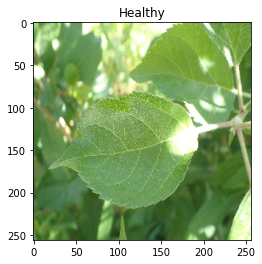

In [91]:
plot_image(testx, testy, 10)

In [215]:
# merging validation batches from the generator
def merge_gendata(generator=valid):
    
    validx = valid[0][0]
    validy = valid[0][1]
    for idx in range(1,4):
        validx = np.concatenate((validx,valid[idx][0]), axis=0)
        validy = np.concatenate((validy,valid[idx][1]), axis=0)
    return validx, validy

In [216]:
validx, validy = merge_gendata(generator=valid)
testx, testy = merge_gendata(generator=test)

In [217]:
# shape checks 
print(validx.shape, validy.shape)
print(testx.shape, testy.shape)

(105, 256, 256, 3) (105, 3)
(105, 256, 256, 3) (105, 3)


In [218]:
# models 
print(os.listdir('./Grid-Eval/Models')[1:])
models = os.listdir('./Grid-Eval/Models')[1:]

['DenseNet121.h5', 'VGG16.h5', 'InceptionV3.h5', 'MobileNetV2.h5', 'Xception.h5', 'VGG19.h5']


### Pipeline run through

In [15]:
# Number of Correct predictions
model = load_model('./Grid-Eval/Models/DenseNet121.h5')

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16777472  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 23,831,619
Trainable params: 16,794,115
Non-trainable params: 7,037,504
__________________________________

In [219]:
dpreds = model.predict(validx) # on augmented set for testing

In [273]:
# dpreds

In [221]:
dpredcls = []
for l in range(0,len(dpreds)):
    dpredcls.append(dpreds[l].argmax())
    

In [225]:
clsmax = []
for l in range(0, len(validy)):
    clsmax.append(validy[l].argmax())

In [228]:
count = 0
for pred, true in zip(dpredcls, clsmax):
    if pred == true:
        count+=1

print(f"{count}/105 are correctly classified")

99/105 are correctly classified


99

In [251]:
confmat = pd.DataFrame(confusion_matrix(dpredcls, clsmax),columns=list(valid.class_indices.keys()))
confmat.index = list(valid.class_indices.keys())
confmat

,Healthy,Powdery,Rust
Healthy,34,2,1
Powdery,0,32,1
Rust,1,1,33


<AxesSubplot:title={'center':'confusion matrix - {}'}>

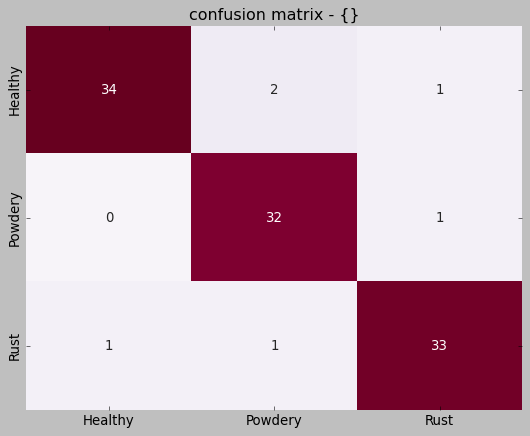

In [263]:
plt.figure(figsize=(8,6))
plt.title('confusion matrix - {}')
plt.style.use('classic')
sns.heatmap(confmat,cmap='PuRd',annot=True,fmt='d',cbar=False)

In [309]:
cls_rep = classification_report(dpredcls,clsmax,output_dict=True)

In [239]:
print(classification_report(dpredcls,clsmax,output_dict=True))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.91      0.97      0.94        33
           2       0.94      0.94      0.94        35

    accuracy                           0.94       105
   macro avg       0.94      0.94      0.94       105
weighted avg       0.94      0.94      0.94       105



In [266]:
with open("Densenettest.txt", 'w') as f:
    f.write('DenseNet\n')
    f.write(classification_report(dpredcls,clsmax))
    

In [327]:
cols = ['Model-Name','Test-Accuracy','Validation-Accuracy', 'F1-Score', 'Recall', 'total-correct-on-validation', 'total-correct-on-test']
report = pd.DataFrame([],columns=cols)
report

,Model-Name,Test-Accuracy,Validation-Accuracy,F1-Score,Recall,total-correct-on-validation,total-correct-on-test


In [295]:
#test 
items  = [23,45,35,45, 45, 46, 64,78]
items = pd.Series(items, index=report.columns)
report = report.append(items, ignore_index=True)
report

,Model-Name,Test-Accuracy,Validation-Accuracy,F1-Score,Recall,Support,total-correct-on-validation,total-correct-on-test
0,23,45,35,45,45,46,64,78
1,23,45,35,45,45,46,64,78
2,23,45,35,45,45,46,64,78


In [298]:
acc = model.evaluate(valid)

4/4 [==============================] - 18s 3s/step - loss: 0.2763 - accuracy: 0.9429


In [325]:
precision,recall,fscore,support=score(dpredcls,clsmax,average='macro')

### Post-Op Reporting Pipeline

In [354]:
def postopreport(test, valid):
    
    
    cols = ['Model-Name','Test-Accuracy','Validation-Accuracy', 'F1-Score', 'Precision', 'Recall', 'total-correct-on-validation/105', 'total-correct-on-test/105']
    report = pd.DataFrame([],columns=cols)
    
    
    models = os.listdir('./Grid-Eval/Models')[1:]
    
#     splitting 
    testx, testy = merge_gendata(generator=test)
    validx, validy = merge_gendata(generator=valid)
    
    for model in models:
        
        modelname = model[:-3]
        print('* {}'.format(modelname,end=', '))

        model = load_model('./Grid-Eval/Models/{}'.format(model))
        
        report_items = []
        report_items.append(modelname)
        
        # test_accuracy 
        test_acc = model.evaluate(test)
        test_acc = test_acc[1]*100
        report_items.append(test_acc)
        
        # valid_accuracy
        valid_acc = model.evaluate(valid)
        valid_acc = valid_acc[1]*100
        report_items.append(valid_acc)
        

        
        vpreds = model.predict(validx)
        tpreds = model.predict(testx)
        
        # softmax probablities to classes
        vpredcls = []
        for l in range(0,len(vpreds)):
            vpredcls.append(vpreds[l].argmax())
        
        tpredcls = []
        for l in range(0,len(tpreds)):
            tpredcls.append(tpreds[l].argmax())
            
        # classes from the y to list
        clsv = []
        for l in range(0, len(validy)):
            clsv.append(validy[l].argmax())
            
        clst = []
        for l in range(0, len(validy)):
            clst.append(validy[l].argmax())
        
        # counts 
        vcount = 0
        for pred, true in zip(vpredcls, clsv):
            if pred == true:
                vcount+=1
        
        # counts 
        tcount = 0
        for pred, true in zip(tpredcls, clst):
            if pred == true:
                tcount+=1
            
        precision,recall,fscore,support=score(tpredcls,clst,average='macro')
        
        report_items.append(fscore*100)
        report_items.append(precision*100)
        report_items.append(recall*100)
        report_items.append(vcount)
        report_items.append(tcount)
        
        report_items = pd.Series(report_items, index=report.columns)
        report = report.append(report_items, ignore_index=True)
        
        print('reported.')
    
    return report
        
        

    

In [355]:
report = postopreport(test,valid)

* DenseNet121
4/4 [==============================] - 17s 4s/step - loss: 0.2523 - accuracy: 0.9619
reported.
* VGG16
4/4 [==============================] - 45s 12s/step - loss: 0.3144 - accuracy: 0.9048
reported.
* InceptionV3
4/4 [==============================] - 14s 3s/step - loss: 0.2365 - accuracy: 0.9333
reported.
* MobileNetV2
4/4 [==============================] - 13s 3s/step - loss: 0.1261 - accuracy: 0.9619
reported.
* Xception
4/4 [==============================] - 17s 4s/step - loss: 0.2763 - accuracy: 0.9429
reported.
* VGG19
4/4 [==============================] - 35s 9s/step - loss: 0.4436 - accuracy: 0.8381
reported.


In [388]:
report['F1-Score'] = report['F1-Score']*100
report['Precision'] = report['Precision']*100
report['Recall'] = report['Recall']*100

In [389]:
report

,Model-Name,Test-Accuracy,Validation-Accuracy,F1-Score,Precision,Recall,total-correct-on-validation/105,total-correct-on-test/105
0,DenseNet121,99.047619,96.190476,96.189893,96.190476,96.215375,101,101
1,VGG16,93.333334,90.476191,90.486965,90.476190,90.835063,95,95
2,InceptionV3,97.142857,93.333334,93.278141,93.333333,93.564107,98,98
3,MobileNetV2,97.142857,96.190476,96.222569,96.190476,96.581197,101,101
4,Xception,94.285715,94.285715,94.282602,94.285714,94.382434,99,99
5,VGG19,85.714287,83.809525,83.989131,83.809524,86.747400,88,88


In [390]:
report.to_csv('plant-diseases-tl-report.csv')

In [391]:
report.iloc[:,1:6].values

array([[99.0476191 , 96.19047642, 96.18989298, 96.19047619, 96.21537504],
       [93.33333373, 90.47619104, 90.48696496, 90.47619048, 90.83506257],
       [97.14285731, 93.33333373, 93.27814124, 93.33333333, 93.5641074 ],
       [97.14285731, 96.19047642, 96.2225691 , 96.19047619, 96.58119658],
       [94.28571463, 94.28571463, 94.28260193, 94.28571429, 94.38243438],
       [85.71428657, 83.80952477, 83.98913113, 83.80952381, 86.74740011]])

In [511]:
y1, y2, y3, y4, y5, y6 = report.iloc[:,1:6].values

In [422]:
f1score = report['F1-Score']
testacc = report['Test-Accuracy']
valacc = report['Validation-Accuracy']
precision = report['Precision']
recall = report['Recall']

In [513]:
report

,Model-Name,Test-Accuracy,Validation-Accuracy,F1-Score,Precision,Recall,total-correct-on-validation/105,total-correct-on-test/105,Elapsed (Mins)
0,DenseNet121,99.047619,96.190476,96.189893,96.190476,96.215375,101,101,30.0
1,VGG16,93.333334,90.476191,90.486965,90.476190,90.835063,95,95,44.0
2,InceptionV3,97.142857,93.333334,93.278141,93.333333,93.564107,98,98,50.0
3,MobileNetV2,97.142857,96.190476,96.222569,96.190476,96.581197,101,101,41.0
4,Xception,94.285715,94.285715,94.282602,94.285714,94.382434,99,99,47.0
5,VGG19,85.714287,83.809525,83.989131,83.809524,86.747400,88,88,46.0


In [515]:
report.iloc[:,1:6]

,Test-Accuracy,Validation-Accuracy,F1-Score,Precision,Recall
0,99.047619,96.190476,96.189893,96.190476,96.215375
1,93.333334,90.476191,90.486965,90.476190,90.835063
2,97.142857,93.333334,93.278141,93.333333,93.564107
3,97.142857,96.190476,96.222569,96.190476,96.581197
4,94.285715,94.285715,94.282602,94.285714,94.382434
5,85.714287,83.809525,83.989131,83.809524,86.747400


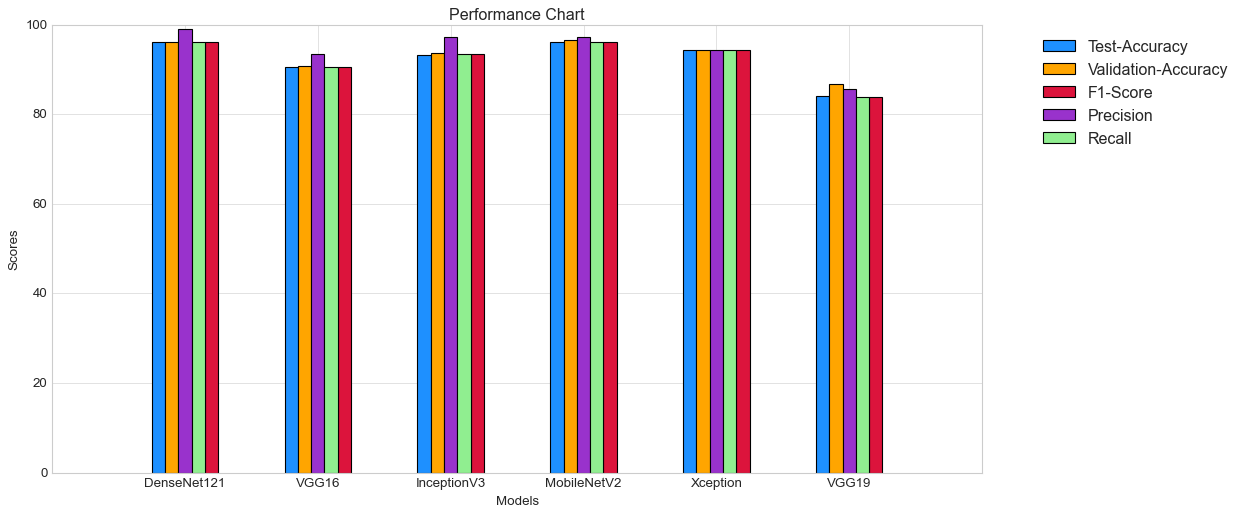

<Figure size 640x480 with 0 Axes>

In [552]:

plt.figure(figsize=(15,7))

x = np.arange(len(report['Model-Name']))
y1 = report['F1-Score']
y2 = report['Recall']
y3 = report['Precision']
y4 = report['Test-Accuracy']
y5 = report['Validation-Accuracy']
width = 0.1

# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='dodgerblue')
plt.bar(x-0.1, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='crimson')
plt.bar(x, y4, width, color='darkorchid')
plt.bar(x+0.1, y5, width, color='lightgreen')
plt.xticks(x, list(report['Model-Name']))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.legend(list(report.iloc[:,1:6].columns),bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Performance Chart')
plt.show()
plt.savefig('performance-chart.png')

In [503]:
# # Grouped Bar chart of performance
# # create data
# df = report.iloc[:,:6]

# # plot grouped bar chart
# df.plot(x='Model-Name',
#         kind='bar',
#         stacked=False,
#         title='Grouped Bar Graph with dataframe')

In [450]:
summarylist = os.listdir('Grid-Eval/')[2:]

In [451]:
summarylist

['MobileNetV2-summary.txt',
 'Xception-summary.txt',
 'DenseNet121-summary.txt',
 'VGG19-summary.txt',
 'InceptionV3-summary.txt',
 'VGG16-summary.txt']

In [572]:
import re 
train = {}
for file in summarylist:
    with open('./Grid-Eval/{}'.format(file),'r') as f:
        content = f.readlines()
        train[file.split('-')[0]]  = float(re.search(r"(\d+.\d+)",content[4])[0])

In [577]:
train

{'MobileNetV2': 95.0,
 'Xception': 92.51,
 'DenseNet121': 96.14,
 'VGG19': 89.26,
 'InceptionV3': 96.0,
 'VGG16': 89.94}

In [554]:
import re 
elapsed = {}
for file in summarylist:
    with open('./Grid-Eval/{}'.format(file),'r') as f:
        content = f.readlines()
        elapsed[file.split('-')[0]]  = float(re.search(r"(\d+.\d+)",content[-2:][0].strip())[0])

In [463]:
elapsed

{'MobileNetV2': 41.0,
 'Xception': 47.0,
 'DenseNet121': 30.0,
 'VGG19': 46.0,
 'InceptionV3': 50.0,
 'VGG16': 44.0}

In [465]:
els = []
for col in report['Model-Name']:
    els.append(elapsed[col])

In [466]:
els

[30.0, 44.0, 50.0, 41.0, 47.0, 46.0]

In [575]:
tn = []
for col in report['Model-Name']:
    tn.append(train[col])

In [576]:
tn

[96.14, 89.94, 96.0, 95.0, 92.51, 89.26]

In [579]:
report['Train-Accuracy'] = tn

In [467]:
report['Elapsed (Mins)'] = els

In [5]:
report = pd.read_csv('plant-diseases-tl-report.csv').drop('Unnamed: 0',axis=1)
report

,Model-Name,Train-Accuracy,Test-Accuracy,F1-Score,Precision,Recall,total-correct-on-test/105,total-correct-on-validation/105,Elapsed (Mins)
0,DenseNet121,96.14,99.047619,96.189893,96.190476,96.215375,101,101,30.0
1,VGG16,89.94,93.333334,90.486965,90.476190,90.835063,95,95,44.0
2,InceptionV3,96.00,97.142857,93.278141,93.333333,93.564107,98,98,50.0
3,MobileNetV2,95.00,97.142857,96.222569,96.190476,96.581197,101,101,41.0
4,Xception,92.51,94.285715,94.282602,94.285714,94.382434,99,99,47.0
5,VGG19,89.26,85.714287,83.989131,83.809524,86.747400,88,88,46.0


In [12]:
valacc= [96.190476, 90.476191,93.333334,96.190476,94.285715,83.809525]
	
report['Validation-Accuracy'] = valacc

In [13]:
cols = ['Model-Name','Train-Accuracy','Test-Accuracy','Validation-Accuracy','F1-Score','Precision','Recall',
       'total-correct-on-test/105','total-correct-on-validation/105','Elapsed (Mins)']
report[cols]

,Model-Name,Train-Accuracy,Test-Accuracy,Validation-Accuracy,F1-Score,Precision,Recall,total-correct-on-test/105,total-correct-on-validation/105,Elapsed (Mins)
0,DenseNet121,96.14,99.047619,96.190476,96.189893,96.190476,96.215375,101,101,30.0
1,VGG16,89.94,93.333334,90.476191,90.486965,90.476190,90.835063,95,95,44.0
2,InceptionV3,96.00,97.142857,93.333334,93.278141,93.333333,93.564107,98,98,50.0
3,MobileNetV2,95.00,97.142857,96.190476,96.222569,96.190476,96.581197,101,101,41.0
4,Xception,92.51,94.285715,94.285715,94.282602,94.285714,94.382434,99,99,47.0
5,VGG19,89.26,85.714287,83.809525,83.989131,83.809524,86.747400,88,88,46.0


In [469]:
report.to_csv('plant-diseases-tl-report.csv')

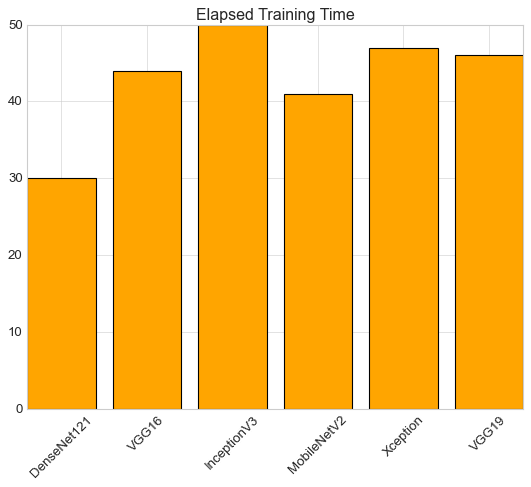

In [502]:
plt.style.use('seaborn-whitegrid')
x = range(len(report['Model-Name']))
y = report['Elapsed (Mins)']

plt.xticks(range(len(report['Model-Name'])),list(report['Model-Name']),rotation=45)
plt.bar(x,y,color='orange',edgecolor='black',width=0.8)
plt.title('Elapsed Training Time')
plt.savefig('elapsed-training-time.png')